In [208]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import lib
from importlib import reload

In [209]:
exp = 7
nside = 2**exp

P_lr = block_diag(np.eye(nside), np.flip(np.eye(nside), axis=1))

for i in range(exp-1):
    P_lr = block_diag(P_lr, P_lr)
    
nsamp = P_lr.shape[0]
P_lr = np.flip(P_lr, axis=0)

P_ud = np.zeros((nsamp, nsamp))

for i, row in enumerate(P_ud):
    chunk = i // nside
    index = i * nside - (chunk * nside**2) + chunk
    if chunk % 2:
        step_size = chunk*nside-(i-nside+1)
        index = nside * step_size + chunk
    row[index]=1

P = np.vstack([P_lr, P_ud])

nsamp = P.shape[0]
rate = 10
seconds = nsamp / rate
times = np.linspace(0, seconds, nsamp)

print(f'Total samples: {nsamp}')
print(f'Total time: {seconds}')

Total samples: 32768
Total time: 3276.8


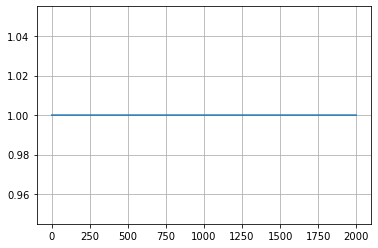

In [353]:
pix_size = 1 #arcmin
ell = np.arange(0, 2000)
Dl = np.ones_like(ell)
plt.plot(ell, Dl)
plt.grid()

/scratch/yuyang/destripe/lib.py:10: RuntimeWarning: divide by zero encountered in true_divide
  Cl = Dl * 2 * np.pi / (ell*(ell+1))
/scratch/yuyang/destripe/lib.py:35: RuntimeWarning: divide by zero encountered in log
  #     plt.imshow(np.log(Cl2d))


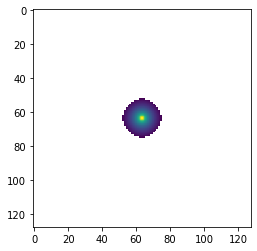

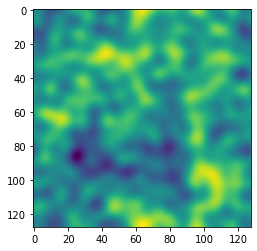

In [395]:
reload(lib)
m_map = lib.generate_map(Dl, nside, pix_size)
plt.imshow(m_map)
m = m_map.flatten()

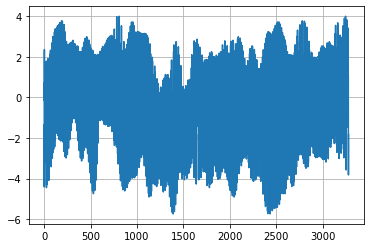

In [355]:
signal = P@m
plt.plot(times, signal)
plt.grid()

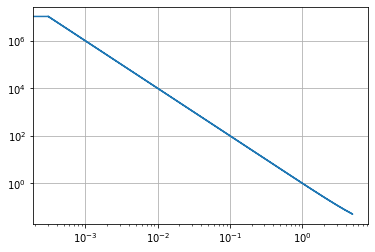

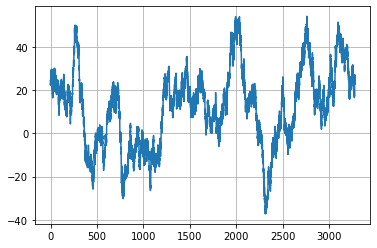

In [385]:
reload(lib)
noise = lib.generate_noise(nsamp, 1/rate, fknee=10, alpha=2, sigma=1e-1)
plt.plot(times, noise)
plt.grid()

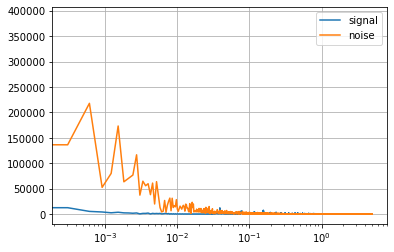

In [399]:
freqs = np.fft.rfftfreq(nsamp, 1/rate)
fft_signal = np.fft.rfft(signal)
fft_noise = np.fft.rfft(noise)
plt.plot(freqs, np.abs(fft_signal), label='signal')
plt.plot(freqs, np.abs(fft_noise), label='noise')
plt.legend()
plt.xscale('log')
# plt.yscale('log')
# plt.ylim([0, 1])
plt.grid()

In [387]:
y = signal + noise # + n

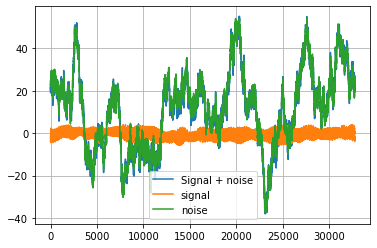

In [388]:
plt.plot(y, label='Signal + noise')
plt.plot(signal, label='signal')
plt.plot(noise, label='noise')
plt.legend()
plt.grid()

In [389]:
#Baselines matrix F
n_baseline = 2**7

F = np.zeros((n_baseline, nsamp))

assert len(y) % n_baseline == 0

cutoff = len(y) // n_baseline
offset = 0 
for i in range(n_baseline):
    F[i][offset:offset+cutoff] = 1
    offset+=cutoff
    
F = F.T

In [390]:
# destriping
Z = np.eye(nsamp) - P @ np.linalg.inv(P.T @ P) @ P.T

#Ax = b
A = F.T @ Z @ F 
b = F.T @ Z @ y

print(A.shape, np.linalg.matrix_rank(A))

# Solution for amplitudes
a = np.linalg.solve(A, b)

(128, 128) 127


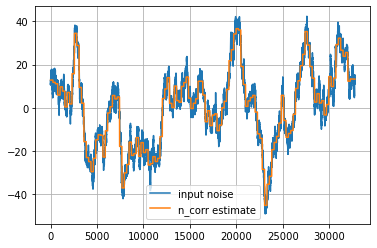

In [391]:
plt.plot(noise - np.mean(noise), label='input noise')
plt.plot(F @ a - np.mean(F@a), label='n_corr estimate')
plt.grid()
plt.legend()

In [392]:
m_solver = np.linalg.inv(P.T @ P) @ P.T

m_destripe = m_solver @ (y - F @ a) #Destriping solution
# m_bin = m_solver @ y #Binned map solution

#remove monopole
m_destripe -= np.mean(m_destripe)
# m_bin -= np.mean(m_bin)

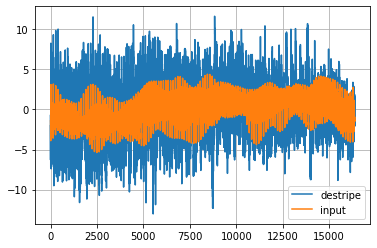

In [393]:
# plt.plot(m_bin, label='bin')
plt.plot(m_destripe, label='destripe')
plt.plot(m - np.mean(m), label='input')
plt.grid()
plt.legend()

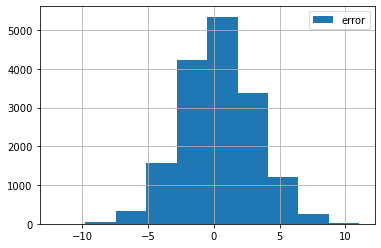

In [394]:
# plt.plot(m_bin - m, label='bin')
plt.hist(m_destripe - m, label='error')
plt.grid()
plt.legend()